# Plotting and comparing best fit models to data for fits to BAOs with and without the phase shift parameter 

### load stuff 

In [50]:
# Import some necessary modules
import os
import sys
sys.path.append("../../Barry/")     # Change this so that it points to where you have Barry installed
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     
from barry.cosmology.camb_generator import Omega_m_z


from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 

# settings 
CV = False 

### load in the data 

In [51]:

datafile="desi_kp4_abacus_cubicbox_pk_elg.pkl"

if CV:
    datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl"


dataset_pk = PowerSpectrum_DESI_KP4(
recon='sym',
fit_poles=[0, 2],
min_k=0.02,
max_k=0.30,
realisation=None,          # realisation=None loads the average of all the realisations
num_mocks=1000,            # Used for Hartlap/Sellentin correction if correction=Correction.HARTLAP or Correction.SELLENTIN
reduce_cov_factor=1,       # if = 1 Use standard covariance, even for the average
datafile=datafile,#"desi_kp4_abacus_cubicbox_pk_elg.pkl",
#datafile="desi_kp4_abacus_cubicbox_cv_pk_elg.pkl",   
data_location="/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles",
)

dataset_pk.set_realisation(None)


### read in the file with the best fit models for the mocks 

In [52]:
directory = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/"
directory2 = "/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/"

#/global/u1/a/abbew25/barryrepo/Barry/cosmodesi_KP4ELG_examplecode_make_picklefiles/plots/desi_kp4_abacus_cubic_ELG/output
#Barry_fit_CV_Pk_Recon.txt 
if CV: 
    file_fits_without_phi = pd.read_csv((directory + "desi_kp4_abacus_cubic_ELG/output/Barry_fit_CVPk_Recon.txt"), header=0, nrows=26)#, index_col=1)
    
    file_fits_with_phi = pd.read_csv((directory2 + "desi_kp4_abacus_cubic_ELG_phaseshiftfree/output/Barry_fit_CVPk_Recon.txt"), header=0, nrows=26)
    
else: 
    file_fits_without_phi = pd.read_csv((directory + "desi_kp4_abacus_cubic_ELG/output/Barry_fit_Pk_Recon.txt"), header=0, nrows=26)
    
    file_fits_with_phi = pd.read_csv((directory2 + "desi_kp4_abacus_cubic_ELG_phaseshiftfree/output/Barry_fit_Pk_Recon.txt"), header=0, nrows=26)
    
#params_model = file_fits_with_phi.to_dict()
#print(params_model)
    
#print(file_fits_without_phi[file_fits_without_phi['Realisation'] == '0'].to_dict())#[' alpha_par'][1])
#print(file_fits_with_phi)#file_fits_with_phi['# Realisation'] == '0'].to_dict())#[' alpha_par'][1])

params_model = file_fits_with_phi.to_dict()

params_model2 = file_fits_without_phi.to_dict()

print(params_model)

{'Realisation': {0: 'mean', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: '10', 12: '11', 13: '12', 14: '13', 15: '14', 16: '15', 17: '16', 18: '17', 19: '18', 20: '19', 21: '20', 22: '21', 23: '22', 24: '23', 25: '24'}, ' alpha_par': {0: 1.0008, 1: 1.0079, 2: 0.985, 3: 1.0236, 4: 1.0263, 5: 1.0127, 6: 1.0008, 7: 1.0004, 8: 1.0187, 9: 0.9946, 10: 0.9818, 11: 1.0002, 12: 0.9945, 13: 0.9975, 14: 1.0, 15: 1.0056, 16: 1.0168, 17: 0.9938, 18: 0.999, 19: 1.0011, 20: 0.9881, 21: 0.9726, 22: 1.0071, 23: 1.0097, 24: 1.0161, 25: 0.9741}, ' alpha_perp': {0: 1.0007, 1: 1.01, 2: 0.9912, 3: 1.0201, 4: 1.0262, 5: 0.9923, 6: 1.0033, 7: 0.9886, 8: 1.0009, 9: 1.0174, 10: 0.9914, 11: 0.9925, 12: 0.9923, 13: 0.9863, 14: 0.9976, 15: 1.0052, 16: 1.0139, 17: 0.989, 18: 1.0037, 19: 1.0049, 20: 0.9951, 21: 0.9877, 22: 1.0179, 23: 1.0072, 24: 1.0023, 25: 0.9835}, ' Sigma_nl_par': {0: 5.5988, 1: 2.7643, 2: 5.6286, 3: 5.04, 4: 6.1354, 5: 4.6939, 6: 4.6204, 7: 5.327, 8: 6.004

### looking at the difference between models with and without phi as a free parameter - on average 

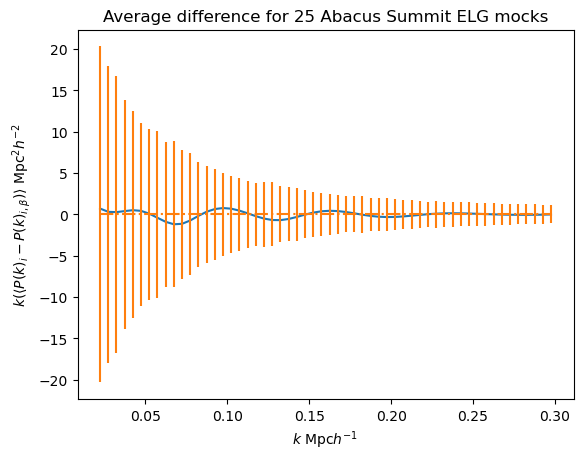

In [53]:

average_diff_modelchoice_fits = np.zeros((len(dataset_pk.ks), 25)) 
                                         
for i in np.arange(25):
                                         
    dataset_pk.set_realisation(i)
    
    modelbest = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k)
                    vary_phase_shift_neff=True, 
                    use_classorcamb='CLASS',
                    marg='full', 
                    dilate_smooth=True
    )
    
    sigma_nl_par = params_model[' alpha_par'][i+1]
    sigma_nl_perp = params_model[' alpha_perp'][i+1]
    sigma_s = params_model[' Sigma_s'][i+1]
    alpha_para = params_model[' Sigma_nl_par'][i+1]
    alpha_perp = params_model[' Sigma_nl_perp'][i+1]
    beta = params_model[' beta'][i+1]

    alpha, epsilon = modelbest.get_reverse_alphas(alpha_para, alpha_perp)

    modelbest.set_default("sigma_nl_par", sigma_nl_par)
    modelbest.set_default("sigma_nl_perp", sigma_nl_perp)
    modelbest.set_default("sigma_s", sigma_s)

    modelbest.set_default("alpha", alpha)
    modelbest.set_default("epsilon", epsilon)
    modelbest.set_default("beta_phase_shift", beta)

    cosmology = {
                "om": 0.3152,
                "h0": 0.6736,
                "z":  0.51,
                "ob": 0.0493,
                "ns": 0.9649,
                "mnu": 0.06,
                "reconsmoothscale": 15,
                "Neff": 3.046,
            }
                                         
    modelbest.set_cosmology(cosmology) # initialises self.camb object 
    modelbest.camb.get_data()
    ks = modelbest.camb.ks
    modelbest.set_data(dataset_pk.get_data())
    params_dict = {j.name: j.default for j in modelbest.params}

    new_chi_squared_best, dof, bband, modsbest, smooths_best = modelbest.get_model_summary(params_dict)
                                         
    
    
    modelbest1 = PowerBeutler2017(
                    recon='sym',                   
                    isotropic=False,                          # Analytic marginalisation
                    n_poly=6,                                 # 6 polynomial terms for P(k) 
                    use_classorcamb='CLASS',
                    marg='full', 
                    dilate_smooth=True
    )

    sigma_nl_par = params_model2[' alpha_par'][i+1]
    sigma_nl_perp = params_model2[' alpha_perp'][i+1]
    sigma_s = params_model2[' Sigma_s'][i+1]
    alpha_para = params_model2[' Sigma_nl_par'][i+1]
    alpha_perp = params_model2[' Sigma_nl_perp'][i+1]

    alpha, epsilon = modelbest1.get_reverse_alphas(alpha_para, alpha_perp)

    modelbest1.set_default("sigma_nl_par", sigma_nl_par)
    modelbest1.set_default("sigma_nl_perp", sigma_nl_perp)
    modelbest1.set_default("sigma_s", sigma_s)

    modelbest1.set_default("alpha", alpha)
    modelbest1.set_default("epsilon", epsilon)
                        
    modelbest1.set_cosmology(cosmology) # initialises self.camb object 
    modelbest1.camb.get_data()
    ks = modelbest1.camb.ks
    modelbest1.set_data(dataset_pk.get_data())
    params_dict = {j.name: j.default for j in modelbest1.params}

    new_chi_squared_best1, dof, bband, modsbest1, smooths_best1 = modelbest1.get_model_summary(params_dict)
                                         
    
    average_diff_modelchoice_fits[:,i] = modsbest1[0][0] - modsbest[0][0] 
                                         
    

average_diff_modelchoice_fits = np.mean(average_diff_modelchoice_fits, axis=1) 
                                         
plt.plot(dataset_pk.ks, average_diff_modelchoice_fits* dataset_pk.ks)
dataset_pk.set_realisation(None)
plt.errorbar(dataset_pk.ks, dataset_pk.data[:,0]-dataset_pk.data[:,0], np.sqrt(np.diag(dataset_pk.cov[0:56,0:56])) * dataset_pk.ks, linestyle='-.')
plt.ylabel(r"$k(\langle P(k)_i - P(k)_{i,\beta}) \rangle$ $\mathrm{Mpc}^2 h^{-2}$")
plt.xlabel(r"$k$ $\mathrm{Mpc} h^{-1}$")
suffix = ''
if CV:
    suffix = ' (CV)'
plt.title("Average difference for 25 Abacus Summit ELG mocks" + suffix)
plt.show()                                        
                                         
